# SLED calculations
In the following I try to calculate the energy gain from a SLED system.

In [1]:
from math import pi
import numpy as np
from numpy import log
from matplotlib import pyplot as plt
from scipy.constants import c
from scipy.interpolate import interp1d
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

This is based on the original Farkas and Wilson paper.

I'm using difference equations to numerically solve the differential equation given in that paper (equation 1, page 2).

$$
T_c\frac{dE_e}{dt} + E_e = -\alpha E_K
$$

In [2]:
time_step = 1e-9
t = np.arange(start=0, stop=10e-6, step=time_step)

Q0 = 1.0e5
beta = 6
omega = 2*pi * 3e9

Tc = (2*Q0) / (omega * (1+beta))
alpha = (2*beta) / (1+beta)

# The following calculates the driving term in the equation. i.e., the
# wave from the klystron
def calc_Ek(t):
    t1 = 3.8e-6  # SLED phase-flip
    t2 = t1 + 0.7e-6  # End of pulse
    t3 = t2 + 0.1e6
    m = -1e100
    if t<t1:
        return -1.0
    elif t<t2:
        return 1.0
    elif t<t3:
        return 1.0
    else:
        return 0.0
        #val = 1.0 + m*(t-t2)
        #if val<0:
        #    val = 0.0
        #return val

Ek = np.array([calc_Ek(i) for i in t])

Ee = [0.0]  # Starting condition
# The following solves the difference equation
for val in Ek:
    Ee.append((1/(Tc+time_step)) * (Tc*Ee[-1] - time_step*alpha*val))
Ee = np.array(Ee[1:])

# The wave arriving at the structure is a combination of the SLED output
# (calculated above), and the forward wave from the klystron
EL = Ee + Ek

Now that the SLED pulse has been calculated, plot everything.

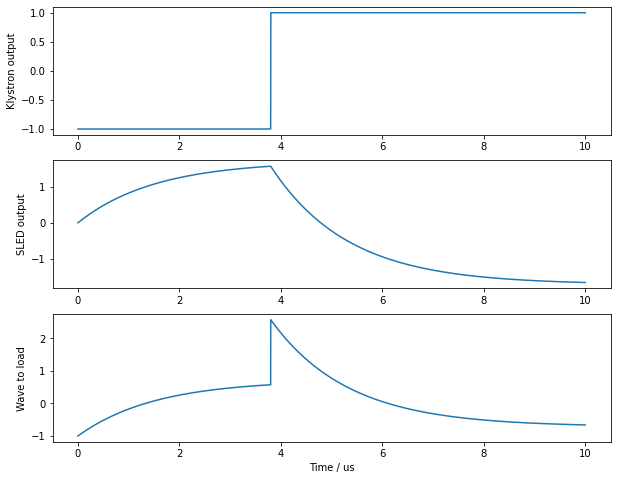

In [3]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 8))

ax[0].plot(t*1e6, Ek)
ax[1].plot(t*1e6, Ee)
ax[2].plot(t*1e6, EL)

ax[2].set_xlabel('Time / us');
ax[0].set_ylabel('Klystron output');
ax[1].set_ylabel('SLED output');
ax[2].set_ylabel('Wave to load');

## Energy gain
In the following I try to follow the Farkas paper to calculate the energy gain as a function of time.

I use the idea from the paper of the delayed arrival of the wave at a point, $z$, in the accelerating structure.  The delay is due to the finite group velocity of the wave.  So for a point, $z$, in the structure, I calculate how long the wave would take to arrive there, and then I use the value of $E_L$ at that delayed time as the value of the wave at that point.

The field at each point in the structure can be calculated in this way, and then the energy gain can be calculated as the integral of this.

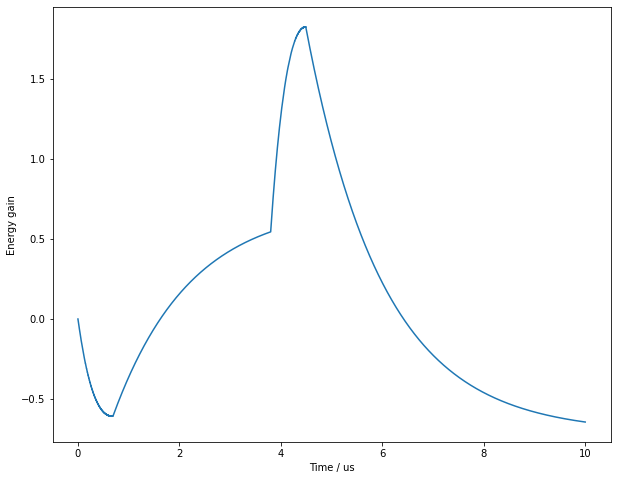

In [4]:
# The following is a simple linear interpolation function for the
# numerically solved E_L that allows its value to be calculated
# for arbitrary times.  If extrapolating beyond the range of the
# numerical data, this will return 0.0
EL_func = interp1d(
    x=t,
    y=EL,
    kind='linear',
    bounds_error=False,
    fill_value=0.0,
    assume_sorted=True
)

# Group velocity at the first and last cells
vg0 = 0.037 * c
vgL = 0.0138 * c
g = (vg0 - vgL) / vg0

# Calculate the acc field at an arbitrary point in the cavity. z_prime = z/L
def E_cavity(z_prime, t):
    L = 5.0
    T_a = (L / (g*vg0)) * log(1 / (1 - g))
    
    delta_t = T_a * (log(1 - g*z_prime) / log(1 - g))
    
    return EL_func(t + z_prime*L/c - delta_t)

# Get the energy gain by integrating over the field
def acc_voltage(t):
    z = np.arange(0, 1, 0.002)
    E = E_cavity(z, t)
    return sum(E) * (z[1] - z[0])

# Plot the result
fig, ax = plt.subplots(figsize=(10, 8))
V = [acc_voltage(t_step) for t_step in t]
ax.plot(t*1e6, V)
ax.set_xlabel('Time / us');
ax.set_ylabel('Energy gain');